# Web scraping

In [43]:
# import
import bs4
import requests
import os
from urllib.parse import urlparse
from dotenv import load_dotenv
from collections import defaultdict


# disable warnings for insecure connections
requests.packages.urllib3.disable_warnings()


In [25]:
load_dotenv()

# constants
HTML_DIR = os.getenv("HTML_DIR")
START_URL = "https://en.wikipedia.org/wiki/Nicolas_Cage"

ALLOW_LIST = ["en.wikipedia.org"]
MAX_DEPTH = 2

if HTML_DIR is None:
    print("HTML_DIR is not set; please set it in .env file or as an environment variable")
    exit(1)

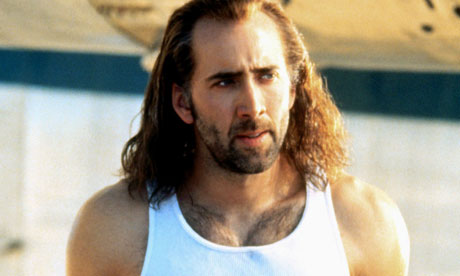

## Fetching the URL

In [26]:
# fetch the HTML of a URL
def fetch_url(url):
    response = requests.get(url, verify=False)
    if response.status_code == 200:
        print("Fetched URL: " + url)
        return response.text
    else:
        print(f"Failed to fetch URL: {url}; ignoring")
        return None

In [27]:
# fetch the HTML of a URL
fetch_url(START_URL)

Fetched URL: https://en.wikipedia.org/wiki/Nicolas_Cage


'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-0 vector-feature-client-preferences-disabled vector-feature-client-prefs-pinned-disabled vector-feature-night-mode-disabled skin-theme-clientpref-day vector-toc-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Nicolas Cage - Wikipedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vecto

## Storing the URL

In [28]:
def store_html(string, path):
  with open(path, 'w') as file:
      file.write(string)
  print(f"Successfully stored in {path}")

def create_path(url):
    return HTML_DIR + url.split("/")[-1] + ".html"

def fetch_and_store(url):
    html = fetch_url(url)
    if html:
        store_html(html, create_path(url))


In [29]:
fetch_and_store(START_URL)

Fetched URL: https://en.wikipedia.org/wiki/Nicolas_Cage
Successfully stored in [REDACTED]/Nicolas_Cage.html


## Prevent duplicate fetches
We want to prevent refetching a URL, if we already have it. An easy way to do this, is to check if the file already exists

In [30]:
def does_file_exist(path):
    return os.path.isfile(path)

def open_html(path):
    with open(path, 'r') as file:
        return file.read()

def fetch_and_store(url):
    path = create_path(url)
    if does_file_exist(path):
        print(f"File already exists: {path}; ignoring")
        return open_html(path)
  
    html = fetch_url(url)
    if html:
        store_html(html, path)

    return html

In [31]:
html = fetch_and_store(START_URL)

File already exists: [REDACTED]/Nicolas_Cage.html; ignoring


## Now to scrape the internet with RECURSION <3
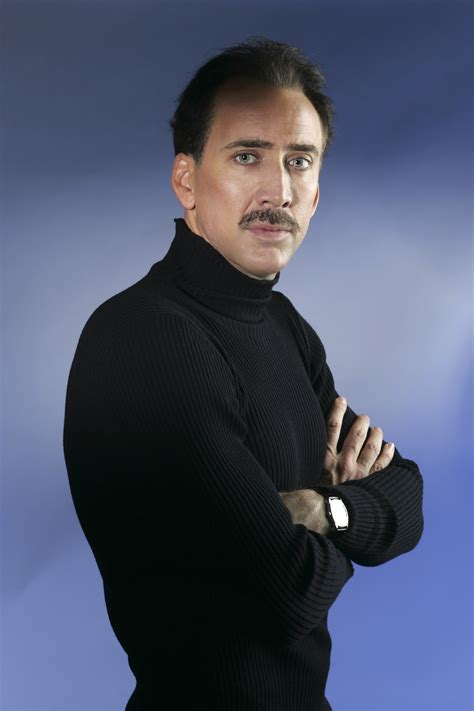

### Parsing the HTML

In [32]:
print(html)

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-0 vector-feature-client-preferences-disabled vector-feature-client-prefs-pinned-disabled vector-feature-night-mode-disabled skin-theme-clientpref-day vector-toc-available" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>Nicolas Cage - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feat

In [33]:
soup = bs4.BeautifulSoup(html, "html.parser")
soup.find_all("a")

[<a class="mw-jump-link" href="#bodyContent">Jump to content</a>,
 <a accesskey="z" href="/wiki/Main_Page" title="Visit the main page [z]"><span>Main page</span></a>,
 <a href="/wiki/Wikipedia:Contents" title="Guides to browsing Wikipedia"><span>Contents</span></a>,
 <a href="/wiki/Portal:Current_events" title="Articles related to current events"><span>Current events</span></a>,
 <a accesskey="x" href="/wiki/Special:Random" title="Visit a randomly selected article [x]"><span>Random article</span></a>,
 <a href="/wiki/Wikipedia:About" title="Learn about Wikipedia and how it works"><span>About Wikipedia</span></a>,
 <a href="//en.wikipedia.org/wiki/Wikipedia:Contact_us" title="How to contact Wikipedia"><span>Contact us</span></a>,
 <a href="https://donate.wikimedia.org/wiki/Special:FundraiserRedirector?utm_source=donate&amp;utm_medium=sidebar&amp;utm_campaign=C13_en.wikipedia.org&amp;uselang=en" title="Support us by donating to the Wikimedia Foundation"><span>Donate</span></a>,
 <a href=

In [34]:
hrefs = [a.get("href") for a in soup.find_all("a")]
hrefs

['#bodyContent',
 '/wiki/Main_Page',
 '/wiki/Wikipedia:Contents',
 '/wiki/Portal:Current_events',
 '/wiki/Special:Random',
 '/wiki/Wikipedia:About',
 '//en.wikipedia.org/wiki/Wikipedia:Contact_us',
 'https://donate.wikimedia.org/wiki/Special:FundraiserRedirector?utm_source=donate&utm_medium=sidebar&utm_campaign=C13_en.wikipedia.org&uselang=en',
 '/wiki/Help:Contents',
 '/wiki/Help:Introduction',
 '/wiki/Wikipedia:Community_portal',
 '/wiki/Special:RecentChanges',
 '/wiki/Wikipedia:File_upload_wizard',
 '/wiki/Main_Page',
 '/wiki/Special:Search',
 '/w/index.php?title=Special:CreateAccount&returnto=Nicolas+Cage',
 '/w/index.php?title=Special:UserLogin&returnto=Nicolas+Cage',
 '/w/index.php?title=Special:CreateAccount&returnto=Nicolas+Cage',
 '/w/index.php?title=Special:UserLogin&returnto=Nicolas+Cage',
 '/wiki/Help:Introduction',
 '/wiki/Special:MyContributions',
 '/wiki/Special:MyTalk',
 '#',
 '#Early_life_and_family',
 '#Career',
 '#1981–1988:_Early_work_and_breakthrough',
 '#1989–1994

In [35]:
def get_partial_urls(html):
    soup = bs4.BeautifulSoup(html, "html.parser")
    return [a.get("href") for a in soup.find_all("a")]

## Going from partial, to full URLS

In [36]:
# filter out non-URLs; i.e. javascript, anchors, and php
def keep_partial_url(url):
  if not url:
    return False

  unallowed = ["javascript", "#", ".php"]
  for i in unallowed:
    if i in url:
      return False

  return True

def keep_full_url(url):
  for i in ALLOW_LIST:
    if i not in url:
      return False
  return True

# starting with double slashes = full URL only missing protocol
def replace_double_slash_with_https(url):
  if len(url) < 2:
    return url

  if url[:2] == "//":
    return f"https:{url[2:]}"

  return url

# add missing protocol to URL
def add_missing_protocol(url):
  if url.startswith("http"):
    return url

  return f"https://{url}"

# get hostname from URL; i.e. https://www.google.com -> www.google.com
def get_hostname(rawurl):
    parsed = urlparse(rawurl)
    return parsed.hostname

# create full URL from relative URL and parent URL
def create_full_url(relative_url, parent_url):
    if relative_url.startswith("http"):
        return relative_url

    if relative_url.startswith("/"):
        return f"{get_hostname(parent_url)}{relative_url}"

    return f"{parent_url}/{relative_url}"

def remove_query(url):
    return url.split("?")[0]


In [37]:
def filter_urls(urls, parent_url):
  for url in urls:
    # remove initial urls
    if not keep_partial_url(url):
      continue
      
    url = replace_double_slash_with_https(url)
    url = create_full_url(url, parent_url)
    url = add_missing_protocol(url)
    url = remove_query(url)
    
    if not keep_full_url(url):
      continue
    
    yield url


gen = filter_urls(hrefs, START_URL)
for i in range(10):
  print(next(gen))

https://en.wikipedia.org/wiki/Main_Page
https://en.wikipedia.org/wiki/Wikipedia:Contents
https://en.wikipedia.org/wiki/Portal:Current_events
https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/Wikipedia:About
https:en.wikipedia.org/wiki/Wikipedia:Contact_us
https://en.wikipedia.org/wiki/Help:Contents
https://en.wikipedia.org/wiki/Help:Introduction
https://en.wikipedia.org/wiki/Wikipedia:Community_portal
https://en.wikipedia.org/wiki/Special:RecentChanges


## Recursion time

In [38]:
def scrape(url, max_depth=0):
  if max_depth > MAX_DEPTH: # max depth reached
    return

  html = fetch_and_store(url)
  if not html:
    return

  partial_urls = get_partial_urls(html)
  gen = filter_urls(partial_urls, url)
  
  for child_url in gen:
    scrape(child_url, max_depth + 1)

In [39]:
scrape(START_URL)

File already exists: [REDACTED]/Nicolas_Cage.html; ignoring
File already exists: [REDACTED]/Main_Page.html; ignoring
File already exists: [REDACTED]/Main_Page.html; ignoring
File already exists: [REDACTED]/Wikipedia:Contents.html; ignoring
File already exists: [REDACTED]/Portal:Current_events.html; ignoring
File already exists: [REDACTED]/Special:Random.html; ignoring
File already exists: [REDACTED]/Wikipedia:About.html; ignoring
File already exists: [REDACTED]/Wikipedia:Contact_us.html; ignoring
File already exists: [REDACTED]/Help:Contents.html; ignoring
File already exists: [REDACTED]/Help:Introduction.html; ignoring
File already exists: [REDACTED]/Wikipedia:Community_portal.html; ignoring
File already exists: [REDACTED]/Special:RecentChanges.html; ignoring
File already exists: [REDACTED]/Wikipedia:File_upload_wizard.html; ignoring
File already exists: [REDACTED]/Main_Page.html; ignoring
File already exists: [REDACTED]/Special:Search.html; ignoring
File already exists: [REDACTED]/He

KeyboardInterrupt: 

# Search engine

We'll keep it basic

In [42]:
%%bash
du -sh $HTML_DIR

3.0G	[REDACTED]/


In [40]:
%%bash
grep -r "Nicolas Cage" $HTML_DIR


[REDACTED]//Kirk_Douglas.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED]//Kirk_Douglas.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED]//Kirk_Douglas.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED]//Geoffrey_Rush.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED]//Geoffrey_Rush.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED]//Geoffrey_Rush.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED]//Geoffrey_Rush.html:<li><span class="nowrap"><a href="/wiki/Nicolas_Cage" title="Nicolas Cage">Nicolas Cage</a> (1995)</span></li>
[REDACTED

What does `grep` do:
- opens every file; line by line
- performs a regex on each line
- prints the line and the file na

Why is this not a good approach for a search engine:
- we open every file; time complexity linear with the amount of files multiplied by the amount of lines => O(l*f) = O(n)

What we want:
- a way to directly find the related files in constant time O(1)


How?
- reverse the problem: don't go from file to query, go from query to file
  - in other words: indexing the files
- what it looks like: `{nuclear: ["file1", "file2"]}`

In [47]:
memory_store = defaultdict(set)

# if the $HTML_DIR is very large, we might run out of memory; therefore advisable to use a database in real-world scenarios
def add_file_path_to_word(file, word):
  memory_store[word].add(file)

def search_word(word):
  return memory_store[word]

In [57]:
def yield_file_paths(path):
  for root, dirs, files in os.walk(path):
    for dir in dirs:
      yield from yield_file_paths(dir)
    for file in files:
      yield os.path.join(root, file)

In [100]:
import re

def get_text_from_html(html):
  soup = bs4.BeautifulSoup(html, "html.parser")
  text = soup.get_text(separator=" ", strip=True)
  words = text.split(" ")

  for word in words:
    # remove numbers
    if re.search(r'\d', word):  
      continue

    # remove special characters
    word = re.sub(r'[^\w\s]', '', word)
    
    # if everything is removed, ignore
    if (word == ""):
      continue


    yield word


In [102]:
gen = get_text_from_html(open_html(create_path(START_URL)))
for i in range(100):
  next(gen)

for i in range(10):
  print(next(gen))


reception
subsection
Nouveau
Shamanic
Examples
History
Reception
Acting
credits
and


**Nouveau Shamanic** hype

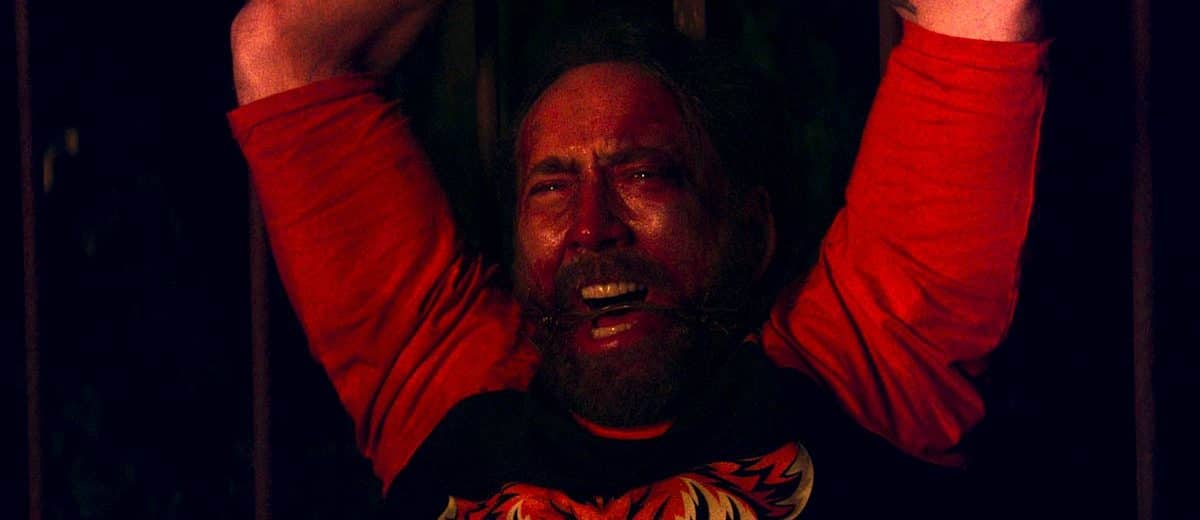


In [115]:
count = 0
paths = yield_file_paths(HTML_DIR)

for path in paths:
  html = open_html(path)
  gen = get_text_from_html(html)
  for word in gen:
    add_file_path_to_word(path, word)

  count+=1

In [116]:
# Cannot find multiple words, so we have to find the documents for each word, and see for which documents they both occur
memory_store["Nicolas Cage"]

set()

In [117]:
memory_store["Nicolas"]

{'[REDACTED]/1798_Rebellion.html',
 '[REDACTED]/1928.html',
 '[REDACTED]/19_martyrs_of_Algeria.html',
 '[REDACTED]/2008_Bucharest_summit.html',
 '[REDACTED]/2008_global_financial_crisis.html',
 '[REDACTED]/2011_Irish_general_election.html',
 '[REDACTED]/2016_United_Kingdom_European_Union_membership_referendum.html',
 '[REDACTED]/2020.html',
 '[REDACTED]/2023%E2%80%9324_Premier_League.html',
 '[REDACTED]/2023.html',
 '[REDACTED]/2024_ATP_Tour.html',
 '[REDACTED]/2024_Mozambique_boat_disaster.html',
 '[REDACTED]/21st_century.html',
 '[REDACTED]/AI_safety.html',
 '[REDACTED]/Abkhazia.html',
 '[REDACTED]/Academy_Award.html',
 '[REDACTED]/Afrikaners.html',
 '[REDACTED]/Agriculture.html',
 '[REDACTED]/Albert,_Prince_Consort.html',
 '[REDACTED]/Alberto_Fujimori.html',
 '[REDACTED]/Alexander_I_of_Yugoslavia.html',
 '[REDACTED]/Alphonse_de_Lamartine.html',
 '[REDACTED]/American_Revolutionary_War.html',
 '[REDACTED]/Ancien_R%C3%A9gime.html',
 '[REDACTED]/Ancient_Egypt.html',
 '[REDACTED]/Angela_

In [118]:
memory_store["Cage"]

{'[REDACTED]/1928.html',
 '[REDACTED]/3rd_Secret.html',
 '[REDACTED]/633_Squadron.html',
 '[REDACTED]/Aberdeen.html',
 '[REDACTED]/Aluminum_foil.html',
 '[REDACTED]/Antony_Blinken.html',
 '[REDACTED]/Aphex_Twin.html',
 '[REDACTED]/Ben_Affleck.html',
 '[REDACTED]/Bob_Mann_(American_football).html',
 '[REDACTED]/Bobby_Sands.html',
 '[REDACTED]/Braveheart.html',
 '[REDACTED]/Britpop.html',
 '[REDACTED]/Bulgaria.html',
 '[REDACTED]/CIMX.html',
 '[REDACTED]/COVID-19_pandemic_in_Quebec.html',
 '[REDACTED]/Category:Wikipedia_articles_incorporating_the_Cite_Grove_template.html',
 '[REDACTED]/Chris_Cornell.html',
 '[REDACTED]/Chuck_Zito.html',
 '[REDACTED]/Coldplay.html',
 '[REDACTED]/Conceptual_art.html',
 '[REDACTED]/Denzel_Washington.html',
 '[REDACTED]/Diocese_in_Europe.html',
 '[REDACTED]/Download_Festival.html',
 '[REDACTED]/Drukqs.html',
 '[REDACTED]/Drum_(container).html',
 '[REDACTED]/Electronic_music.html',
 '[REDACTED]/Elton_John.html',
 '[REDACTED]/Fleetwood_Mac.html',
 '[REDACTED]/

In [113]:
def query(q):
  query_words = q.split(" ")

  result = None
  for word in query_words:
    if result is None:
      result = search_word(word)
    else:
      # intersection of results; i.e. where both words are present
      result = result.intersection(search_word(word))
  
  return result

In [119]:
query("Nicolas Cage")

{'[REDACTED]/1928.html',
 '[REDACTED]/Ben_Affleck.html',
 '[REDACTED]/COVID-19_pandemic_in_Quebec.html',
 '[REDACTED]/Conceptual_art.html',
 '[REDACTED]/Denzel_Washington.html',
 '[REDACTED]/Diocese_in_Europe.html',
 '[REDACTED]/Electronic_music.html',
 '[REDACTED]/Francis_Bacon_(artist).html',
 '[REDACTED]/Geoffrey_Rush.html',
 '[REDACTED]/Kenneth_Branagh.html',
 '[REDACTED]/Kirk_Douglas.html',
 '[REDACTED]/Nicolas_Cage.html',
 '[REDACTED]/Ridley_Scott.html',
 '[REDACTED]/Wikipedia:Featured_lists.html'}

In [120]:
query("Nouveau Shamanic")

{'[REDACTED]/Nicolas_Cage.html'}

Now we can query in constant time! At the cost of up-front indexing

What's next (and the magic sauce of any good search engine):
- ordering the results:
  - Google got big because of their [PageRank algorithm](https://en.wikipedia.org/wiki/PageRank) => basically, giving a authority weight to pages based on the amount of in-links
  - Distinguish between important words and non-important words using [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) => for example querying "a nuclear powerplant", we do not care to receive all documents with the "a" term.
- semantic interpretation
  - words have common meaning; we should be able to find what we want even if we do not 
  - [read more about transforming a word into a matrix containing its "meaning"](https://en.wikipedia.org/wiki/Latent_semantic_analysis)

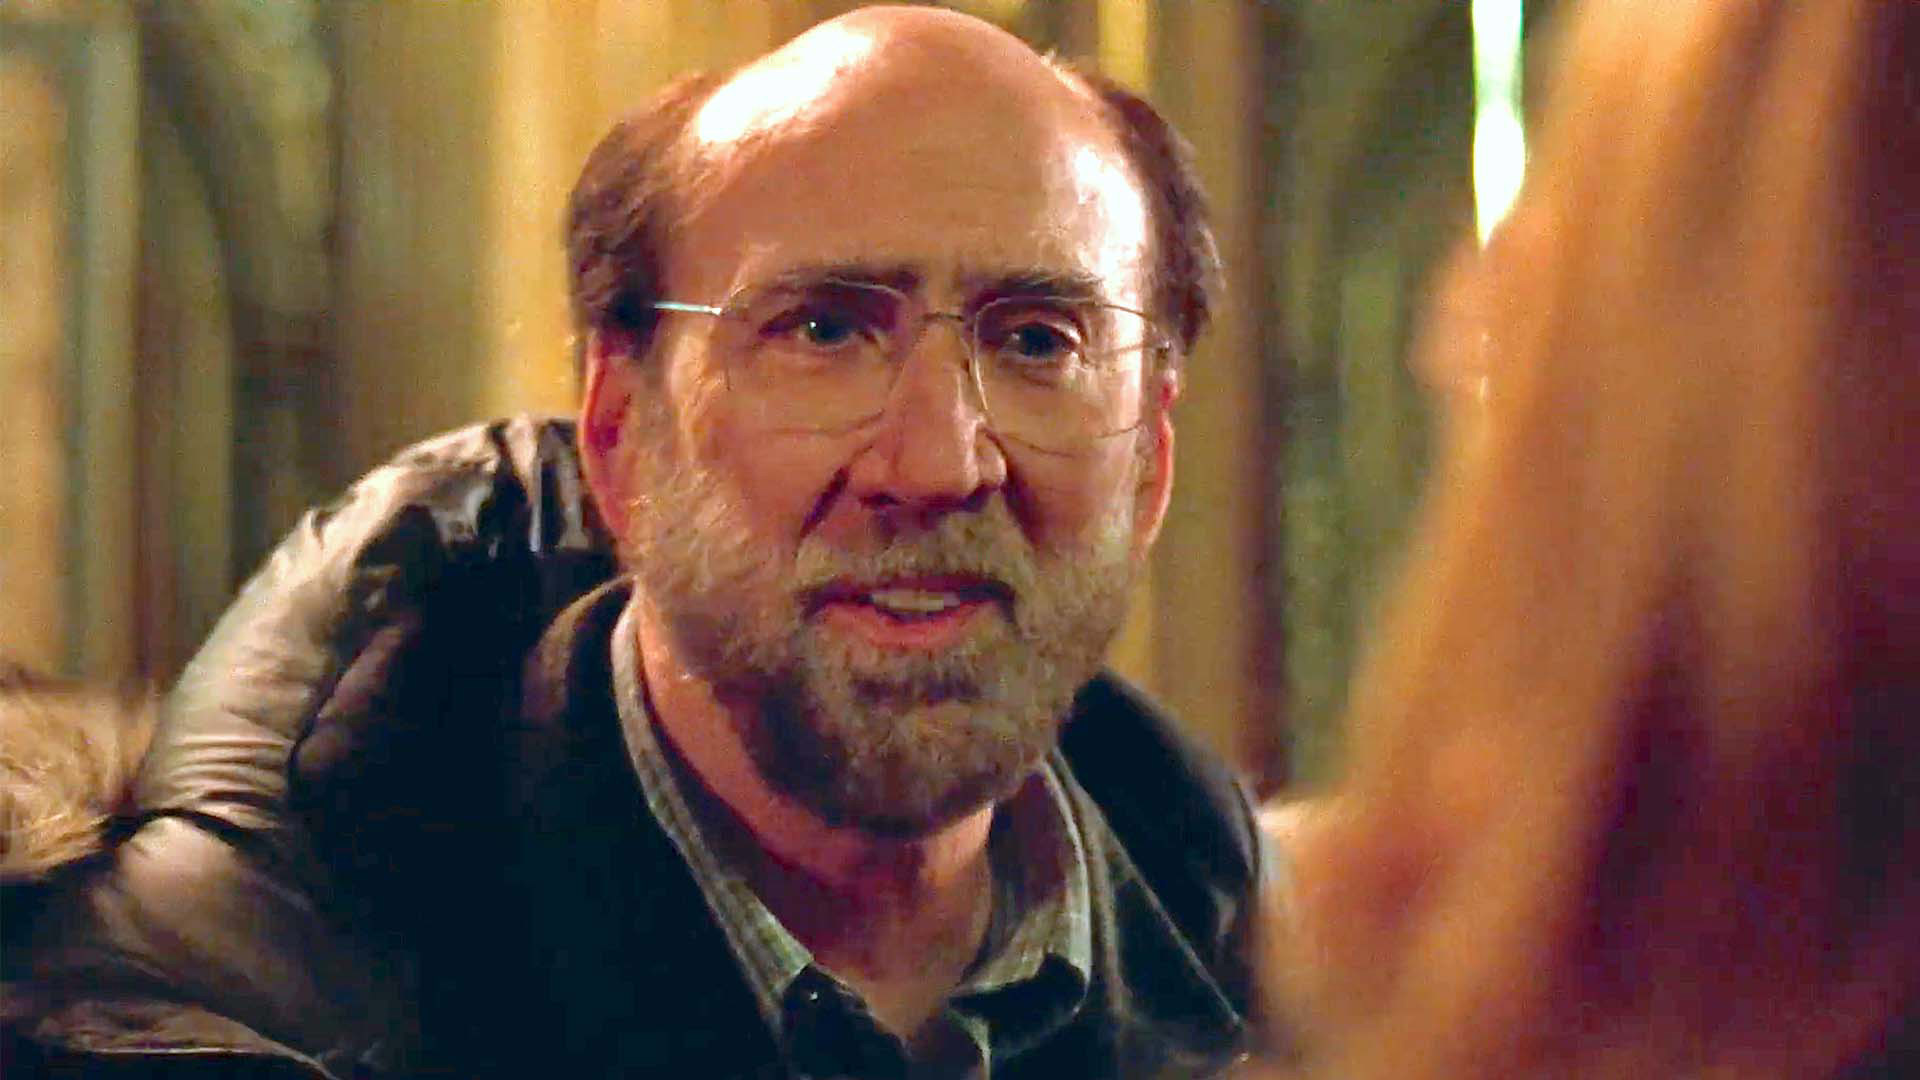

In [123]:
import json

# Convert memory_store to a dictionary
memory_store_dict = dict(memory_store)

def set_default(obj):
    if isinstance(obj, set):
        return list(obj)
    raise TypeError

# Write memory_store_dict to memory_store.json file
with open('.memory_store.json', 'w') as file:
    json.dump(memory_store_dict, file, default=set_default)
